# Data and module import

In [ ]:
import pandas as pd; import numpy as np; import pymc as pm; from scipy import stats; import arviz as az

In [ ]:
#Accidents after June 2008
data = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA303/main/cyclingData.csv")

## Data cleaning

In [ ]:
def TimeGetter(time):
    ftr = [3600,60,1]
    t = sum([a*b for a,b in zip(ftr, map(int,time.split(':')))])
    if t<6*3600 or t>22*3600:
        return "Night"
    elif t<9*3600:
        return "Morning"
    elif t<14*3600:
        return "Midday"
    elif t<18*3600:
        return "Afternoon"
    else:
        return "Evening"

In [ ]:
# Missing data
# Substitute missing data with NA
data = data.replace({'Missing Data': np.NAN, 'Other': np.NAN, 'Unknown': np.NAN, 'Missing data': np.NAN})
# Assume data is missing completely at random and remove
data = data.dropna()
#data["Road_conditions"].unique()

# Data wrangling
# Day to weekday(1) and weekend(0)
data = data.replace({'Monday':1, 'Tuesday':1, 'Wednesday':1, 'Thursday':1, 'Friday': 1, 'Saturday':0, 'Sunday': 0})
# TimeDay variable, categorical

data["TimeDay"] = [TimeGetter(i) for i in data["Time"]]
# Road conditions: Dry or not
data["DryRoad"] = [1 if i=="Dry" else 0 for i in data["Road_conditions"]]

# Weather: Clear or not
data["Clear"] = [1 if i=="Clear" else 0 for i in data["Weather_conditions"]]

# Light conditions: Dark or not
data["Dark"] = [1 if i=="Darkness no lights" else 0 for i in data["Light_conditions"]]
print(data['Light_conditions'].unique())
# Road type: Binary whether it is Dual carriageway, use EDA to justify
data["DualCarriageway"] = [1 if i=="Dual carriageway" else 0 for i in data["Road_type"]]
# Age: over 55
data["over55"] = [1 if i in ["56 to 65", "66 to 75"] else 0 for i in data["Age_Grp"]]

# Severity_binary: Severe or not
data["Severity_binary"] = [0 if i=="Slight" else 1 for i in data["Severity"]]

# Night binary
data["Night"] = [1 if i=="Night" else 0 for i in data["TimeDay"]]
# Morning binary
data["Morning"] = [1 if i=="Morning" else 0 for i in data["TimeDay"]]
# Midday binary
data["Midday"] = [1 if i=="Midday" else 0 for i in data["TimeDay"]]
# Afternoon binary
data["Afternoon"] = [1 if i=="Afternoon" else 0 for i in data["TimeDay"]]
# Evening binary
data["Evening"] = [1 if i=="Evening" else 0 for i in data["TimeDay"]]
data['Gender']= [1 if i=="Male" else 0 for i in data["Gender"]]

cleandata = data[["Severity_binary", "Day", "Speed_limit", "DryRoad", "Clear", "Gender", "over55", "DualCarriageway", "TimeDay", "Night", "Morning", "Midday", "Afternoon", "Evening", "Dark"]]
cleandata.head(10)


['Darkness lights lit' 'Daylight' 'Darkness no lights']


,Severity_binary,Day,Speed_limit,DryRoad,Clear,Gender,over55,DualCarriageway,TimeDay,Night,Morning,Midday,Afternoon,Evening,Dark
0,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
1,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
2,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
3,0,0,30,1,1,1,0,0,Midday,0,0,1,0,0,0
4,0,1,30,1,1,1,0,0,Evening,0,0,0,0,1,0
5,0,1,30,1,1,0,1,0,Evening,0,0,0,0,1,0
6,0,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0
7,0,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0
8,0,1,30,1,1,1,0,0,Midday,0,0,1,0,0,0
9,1,1,30,1,1,0,0,0,Afternoon,0,0,0,1,0,0


In [ ]:
len(cleandata)

173453

In [ ]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

# We want model with three predictors: When, What, Who

# Hierarchical structure on Time/Day betas

In [ ]:
# Hierarchical structure on Time/Day betas

with pm.Model() as timeday_model:

    # p_day Probablity of being a weekday
    p_day = pm.Beta('p_day', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    p02= pm.Beta('p02', alpha=1, beta=1)
    p03= pm.Beta('p03', alpha=1, beta=1)
    p04= pm.Beta('p04', alpha=1, beta=1)
    p05= pm.Beta('p05', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    p12= pm.Beta('p12', alpha=1, beta=1)
    p13= pm.Beta('p13', alpha=1, beta=1)
    p14= pm.Beta('p14', alpha=1, beta=1)

    # p02 + p_day*(1-p02)*p12
    no_negatives_2 = pm.math.switch(pm.math.lt(p02 + p_day*(1-p02)*p12,0), 0, p02 + p_day*(1-p02)*p12)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, p02 + p_day*(1-p02)*p12)
    p2 = pm.Deterministic('p2', in_unit_interval_2)

    # p03 - p_day*(1-p03)*p13
    no_negatives_3 = pm.math.switch(pm.math.lt(p03 - p_day*(1-p03)*p13,0), 0, p03 - p_day*(1-p03)*p13)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, p03 - p_day*(1-p03)*p13)
    p3 = pm.Deterministic('p3', in_unit_interval_3)

    # p04 + p_day*(1-p04)*p14
    no_negatives_4 = pm.math.switch(pm.math.lt(p04 + p_day*(1-p04)*p14,0), 0, p04 + p_day*(1-p04)*p14)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, p04 + p_day*(1-p04)*p14)
    p4 = pm.Deterministic('p4', in_unit_interval_4)

    # Linear combination of predictors
    logit_p = pNight*x6 +p2*x7 +p3*x8 +p4*x9 +p05*x10
    logit_p = pm.Deterministic('logit_p',logit_p)

    y = pm.Bernoulli('y', logit_p = logit_p, observed = y)

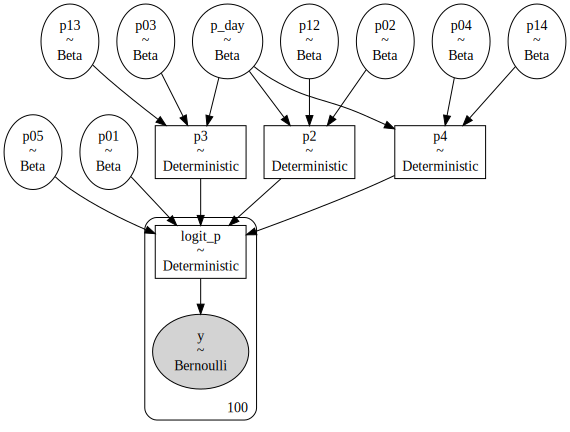

In [ ]:
pm.model_to_graphviz(timeday_model)

# Posterior inference: Variable selection for the conditions factors using Spike and Slab

In [ ]:
predictors = ['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit']

# Get predictors and target variable as numpy arrays
X = cleandata[predictors].values[-100:]
y = cleandata['Severity_binary'].values[-100:]

# Number of predictors
n_predictors = X.shape[1]

# Define Bayesian binary regression model with spike-and-slab priors for variable selection
with pm.Model() as model:
    # Coefficients for predictors
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_predictors)

    # Indicator variables for spike-and-slab
    gamma = pm.Bernoulli('gamma', p=0.5, shape=n_predictors)

    # Create deterministic variable for selected coefficients
    beta_selected = pm.Deterministic('beta_selected', beta * gamma)

    # Logistic regression model
    p = pm.math.invlogit(pm.math.dot(X, beta_selected))

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    idata = pm.sample()
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=False)

# Extract selected predictors based on posterior samples of gamma
selected_predictors = np.array(predictors)[np.mean(trace['gamma'], axis=0) > 0.5]
print("Selected predictors:", selected_predictors)

Selected predictors: ['Dark' 'Clear']


[Text(1, 0, 'DryRoad'),
 Text(2, 0, 'Dark'),
 Text(3, 0, 'DualCarriageway'),
 Text(4, 0, 'Clear'),
 Text(5, 0, 'Speed_limit')]

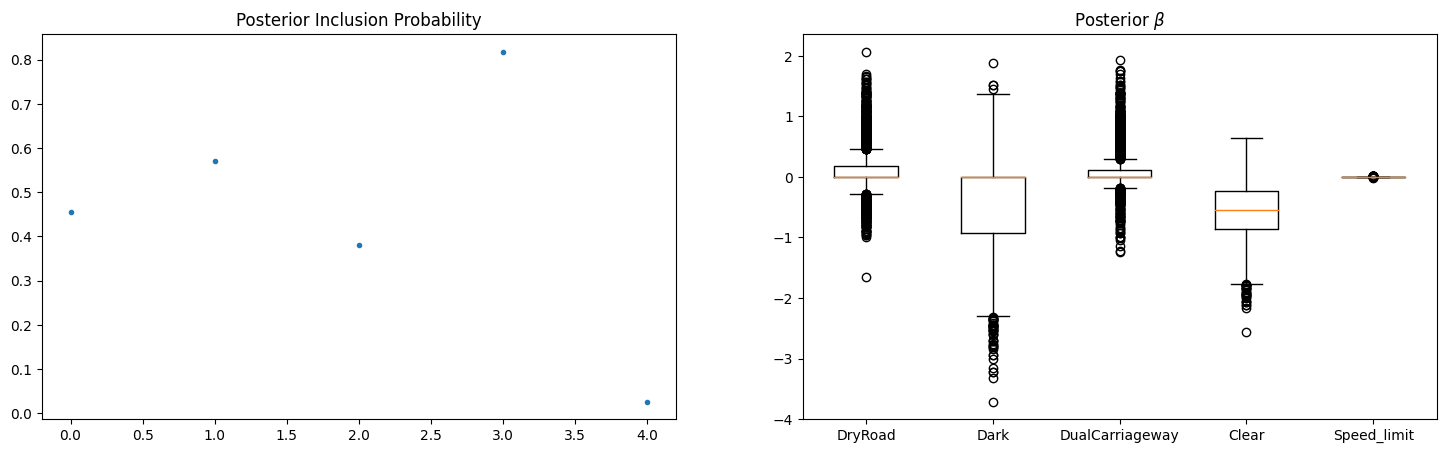

In [ ]:
# Spike and Slab variable selection plots: only the second and the fourth betas have inclusion probability > 0.5
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(18,5));

num_of_beta = 5
ax[0].plot(idata.posterior['gamma'].values.reshape((-1,num_of_beta)).mean(axis=0),'.');
ax[0].set_title('Posterior Inclusion Probability');
ax[1].boxplot(idata.posterior['beta_selected'].values.reshape((-1,num_of_beta)));
ax[1].set_title('Posterior $\\beta$');
ax[1].set_xticklabels(['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit'])

In the plot above we see that DryRoad and DualCarriageway were both not selected and they were slabbed to zero

# Combine selected predictors with hierarchical model established earlier

In [ ]:
with pm.Model() as complete_model:

    # p_day Probablity of being a weekday
    p_day = pm.Beta('p_day', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    p02= pm.Beta('p02', alpha=1, beta=1)
    p03= pm.Beta('p03', alpha=1, beta=1)
    p04= pm.Beta('p04', alpha=1, beta=1)
    p05= pm.Beta('p05', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    p12= pm.Beta('p12', alpha=1, beta=1)
    p13= pm.Beta('p13', alpha=1, beta=1)
    p14= pm.Beta('p14', alpha=1, beta=1)

    # p02 + p_day*(1-p02)*p12
    no_negatives_2 = pm.math.switch(pm.math.lt(p02 + p_day*(1-p02)*p12,0), 0, p02 + p_day*(1-p02)*p12)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, p02 + p_day*(1-p02)*p12)
    p2 = pm.Deterministic('p2', in_unit_interval_2)

    # p03 - p_day*(1-p03)*p13
    no_negatives_3 = pm.math.switch(pm.math.lt(p03 - p_day*(1-p03)*p13,0), 0, p03 - p_day*(1-p03)*p13)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, p03 - p_day*(1-p03)*p13)
    p3 = pm.Deterministic('p3', in_unit_interval_3)

    # p04 + p_day*(1-p04)*p14
    no_negatives_4 = pm.math.switch(pm.math.lt(p04 + p_day*(1-p04)*p14,0), 0, p04 + p_day*(1-p04)*p14)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, p04 + p_day*(1-p04)*p14)
    p4 = pm.Deterministic('p4', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = intercept + pNight*x6 +p2*x7 +p3*x8 +p4*x9 +p05*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Y = pm.Bernoulli('Y', logit_p = logit_p, observed=y)

    idata_2 = pm.sample()

# Model diagnostic Part I

In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete) # or pass `idata_kwargs={"log_likelihood": True}` to `pm.sample`

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)

In [ ]:
az.waic(trace_complete)

<ipython-input-26-dbc902779305>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_complete)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -67.58     2.57
p_waic        2.68        -

In [ ]:
az.waic(trace_basic)

<ipython-input-27-ccd65360a166>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_basic)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -68.80     2.92
p_waic        4.37        -

In [ ]:
az.compare({"complete model": trace_complete, "basic model": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complete_model,0,-67.575531,2.677865,0.000000,1.0,2.569283,0.000000,False,log
model2,1,-68.799189,4.366537,1.223658,0.0,2.919276,0.887012,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

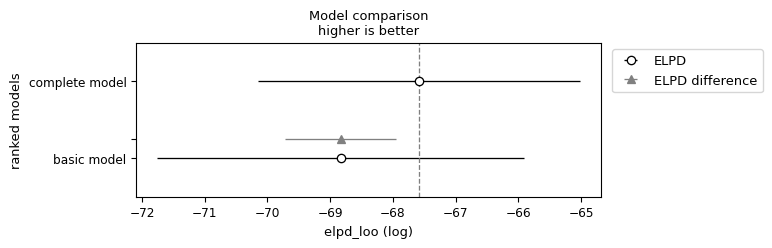

In [ ]:
az.plot_compare(az.compare({ "complete model": trace_complete, "basic model": trace_basic}), insample_dev=False)

# Mixture model

In [ ]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

xover55 = subset["over55"]
xover55 = pd.Series(xover55).array

xGender = subset["Gender"]
xGender = pd.Series(xGender).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

In [ ]:
with pm.Model() as mixture_model:
    # Define mixture proportions for over55 and Gender
    p_over55 = pm.Dirichlet('p_over55', a=np.ones(2))
    p_gender = pm.Dirichlet('p_gender', a=np.ones(2))

    # Mixture component parameters for over55
    alpha_over55 = pm.Normal('alpha_over55', mu=0, sigma=1, shape=(2,))
    beta_over55 = pm.Normal('beta_over55', mu=0, sigma=1, shape=(2,))

    # Mixture component parameters for Gender
    alpha_gender = pm.Normal('alpha_gender', mu=0, sigma=1, shape=(2,))
    beta_gender = pm.Normal('beta_gender', mu=0, sigma=1, shape=(2,))

    # Mixture probabilities
    over55_component = pm.Categorical('over55_component', p=p_over55, shape=xover55.shape[0])
    gender_component = pm.Categorical('gender_component', p=p_gender, shape=xGender.shape[0])

    # Mixture linear combinations for over55 and Gender
    over55_logit = alpha_over55[over55_component] + beta_over55[over55_component] * xover55
    gender_logit = alpha_gender[gender_component] + beta_gender[gender_component] * xGender

    # p_day Probablity of being a weekday
    p_day = pm.Beta('p_day', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    p02= pm.Beta('p02', alpha=1, beta=1)
    p03= pm.Beta('p03', alpha=1, beta=1)
    p04= pm.Beta('p04', alpha=1, beta=1)
    p05= pm.Beta('p05', alpha=1, beta=1) ## = p5

    # Time weekend probabilities
    p12= pm.Beta('p12', alpha=1, beta=1)
    p13= pm.Beta('p13', alpha=1, beta=1)
    p14= pm.Beta('p14', alpha=1, beta=1)

    # p02 + p_day*(1-p02)*p12
    no_negatives_2 = pm.math.switch(pm.math.lt(p02 + p_day*(1-p02)*p12,0), 0, p02 + p_day*(1-p02)*p12)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, p02 + p_day*(1-p02)*p12)
    p2 = pm.Deterministic('p2', in_unit_interval_2)

    # p03 - p_day*(1-p03)*p13
    no_negatives_3 = pm.math.switch(pm.math.lt(p03 - p_day*(1-p03)*p13,0), 0, p03 - p_day*(1-p03)*p13)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, p03 - p_day*(1-p03)*p13)
    p3 = pm.Deterministic('p3', in_unit_interval_3)

    # p04 + p_day*(1-p04)*p14
    no_negatives_4 = pm.math.switch(pm.math.lt(p04 + p_day*(1-p04)*p14,0), 0, p04 + p_day*(1-p04)*p14)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, p04 + p_day*(1-p04)*p14)
    p4 = pm.Deterministic('p4', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    # Combine over55 and Gender mixtures
    logit_p = intercept + pNight * x6 + p2 * over55_logit + p3 * gender_logit + p4 * x9 + p05 * x10 + beta_clear * x2 + beta_dark * x4
    logit_p = pm.Deterministic('logit_p', logit_p)

    # Define likelihood
    Y_mixture = pm.Bernoulli('Y_mixture', logit_p=logit_p, observed=y)

    # Sample the model
    idata_4 = pm.sample()

KeyboardInterrupt: 

In [ ]:
pm.model_to_graphviz(mixture_model)

In [ ]:
az.plot_trace(idata_4, combined=True);
az.summary(idata_4, round_to=2)

NameError: name 'az' is not defined

# Model diagnostic Part II



In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with mixture_model:
    trace_mix = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_mix)

with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete)

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)


In [ ]:
az.waic(trace_mix)

<ipython-input-21-6b3c8ef858ff>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_mix)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -66.80     2.87
p_waic        9.11        -

In [ ]:
az.compare({"mixture_model": trace_mix, "complete_model": trace_complete, "model2": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
mixture_model,0,-66.797920,9.106353,0.000000,1.000000e+00,2.865732,0.000000,False,log
complete_model,1,-67.575531,2.677865,0.777611,2.012279e-15,2.569283,0.927726,False,log
model2,2,-68.799189,4.366537,2.001269,0.000000e+00,2.919276,0.868496,False,log


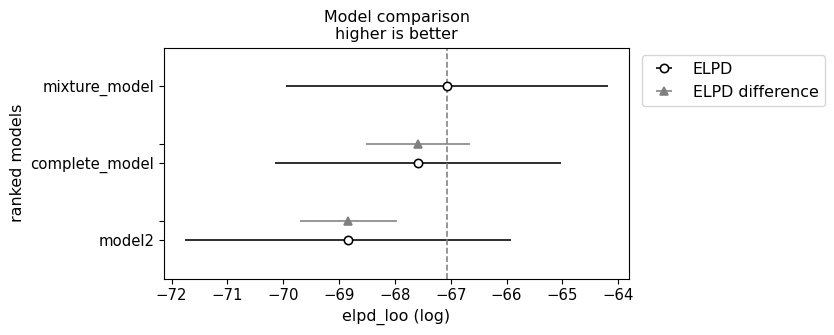

In [ ]:
az.plot_compare(az.compare({"mixture_model": trace_mix, "complete_model": trace_complete, "model2": trace_basic}), insample_dev=False);